In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from SALib.analyze import sobol
import warnings
from ema_workbench.analysis import feature_scoring
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
import ema_workbench.em_framework.optimization
from ema_workbench.em_framework.optimization import to_problem, epsilon_nondominated, EpsilonProgress, ArchiveLogger
from ema_workbench import (
    Model,
    Policy,
    ScalarOutcome,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    perform_experiments,
    Samplers,
)


from dike_model_function import DikeNetwork
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time
from ema_workbench.analysis import prim
from ema_workbench.em_framework.parameters import Constant
import pickle
warnings.filterwarnings("ignore")
ema_logging.log_to_stderr(ema_logging.INFO)


<Logger EMA (DEBUG)>

## Incoming Files

In [2]:
# Model
dike_model, planning_steps = get_model_for_problem_formulation(2)

In [3]:
# Load results from DB
scenario_results = []
seeds = [27097, 567, 45646, 90, 676465]  # seeds used un DB - to change later
for seed in seeds:
    df = pd.read_csv(f"output/results_seed_{seed}.csv")  # Use '/'
    scenario_results.append(df)
    l = df.columns.tolist()
len(l)

37

In [6]:
# Load archive
archive_results = []
seeds = [27097, 567, 45646, 90, 676465]  # seeds used un DB - to change later
for seed in seeds:
   archives = ArchiveLogger.load_archives(f"output/seed_{seed}_archive.tar.gz")  # Use '/'
   #for key in archives.keys():
   archive_results.append(archives)

In [7]:
pol = []
for policy in dike_model.levers:
    pol.append(policy)

for outcome in dike_model.outcomes:
    pol.append(outcome)

len(pol)
dike_model_problem =dike_model
dike_model_problem.outcomes

## Merge Seeds

In [8]:
for archive in archive_results:
    for key, df in archive.items():
        for col in dike_model.levers:
            if col.name not in df.columns:
                df[col.name] = 0

In [9]:
#Make sure that the results contain all policies (rest is set to 0)
for df in scenario_results:
    for col in dike_model.levers:
        if col.name not in df.columns:
            df[col.name] = 0

In [10]:
#Rename problem levers and outcomes to compatible name format
original_lever_names = []
for lever in dike_model_problem.levers:
    original_lever_names.append(lever.name)
    lever.name = 'L_' + lever.name.replace(" ", "_").replace(".", "_")

original_outcome_names =[]
for outcome in dike_model_problem.outcomes:
    original_outcome_names.append(outcome.name)
    outcome.name = 'L_' + outcome.name.replace(" ", "_").replace(".", "_")

In [11]:
#Defining the problem
problem = to_problem(dike_model_problem, searchover="levers")

In [12]:
#Rename the scenario levers and outcomes

def clean_names(name_list):
    return ['L_' + name.replace(" ", "_").replace(".", "_") for name in name_list]

# Clean column names in the scenario results
original_parameter_names = scenario_results[0].columns
for i in range(len(scenario_results)):
    scenario_results[i].columns = clean_names(scenario_results[i].columns)

In [13]:
#Merge the results from the different seeds for each of the two scenarios
epsilons = [0.05] * len(dike_model.outcomes)

#Merge the list of results into a single set of non dominated results using the provided epsilon values
merged_results = epsilon_nondominated(scenario_results,epsilons,problem)

In [14]:
len(merged_results)

719

In [15]:
for lever, original_name in zip(dike_model.levers, original_lever_names):
    lever.name = original_name

for outcome, original_name in zip(dike_model.outcomes, original_outcome_names):
    outcome.name = original_name

In [16]:
merged_results.columns = original_parameter_names

## Policies: TO ADD MORE FILTERS

In [17]:
# Further filter results based on a threshold for total costs
results_filter = merged_results[merged_results['Expected Number of Deaths']==0]
results_filter.to_excel('Results Filter.xlsx')
policies_ = results_filter
len(policies_)

13

<Figure size 3000x500 with 0 Axes>

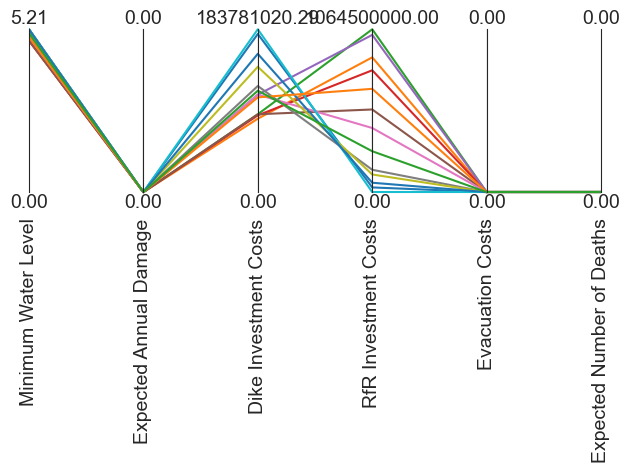

In [18]:
from ema_workbench.analysis import parcoords

data = policies_.loc[:, [o.name for o in dike_model.outcomes]]
limits = parcoords.get_limits(data)
limits.loc[0, [o.name for o in dike_model.outcomes]] = 0

plt.figure(figsize=(30, 5))
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
#paraxes.invert_axis('A.5_Minimum Water Level')
plt.show()

## Candidate Strategies
Re evaluate candidate solutions to assess their robustness. Run EMA workbench again. Reduce the size of the list of the robust policies by adding extra constaints (Insights on the debate)



In [19]:
# Create a list with a format EMA workbench can use
from ema_workbench import Policy

policies_.index = [i for i in range(len(policies_.index))]

# Drop the outcome columns from the policies DataFrame, keeping only the decision variables
policies_pareto = policies_.drop([o.name for o in dike_model.outcomes], axis=1)

policies_to_analyze = []

# Create policy objects
for i, policy in policies_.iterrows():
    policies_to_analyze.append(Policy(str(i), **policy.to_dict()))

In [21]:
# Run experiments again only on selected robust policies
n_scenarios = 6000
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,
                                            policies_to_analyze)

experiments, outcomes = results

[MainProcess/INFO] pool started with 12 workers
[MainProcess/INFO] performing 6000 scenarios * 13 policies * 1 model(s) = 78000 experiments
100%|██████████████████████████████████| 78000/78000 [2:32:48<00:00,  8.51it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [22]:
#Saving the results just to be sure
outcomes2 = pd.DataFrame.from_dict(outcomes)
outcomes2.to_csv('Results/Robustness_outcomes.csv')
experiments.to_csv('Results/Robustness_experiments.csv')

[MainProcess/INFO] no time dimension found in results


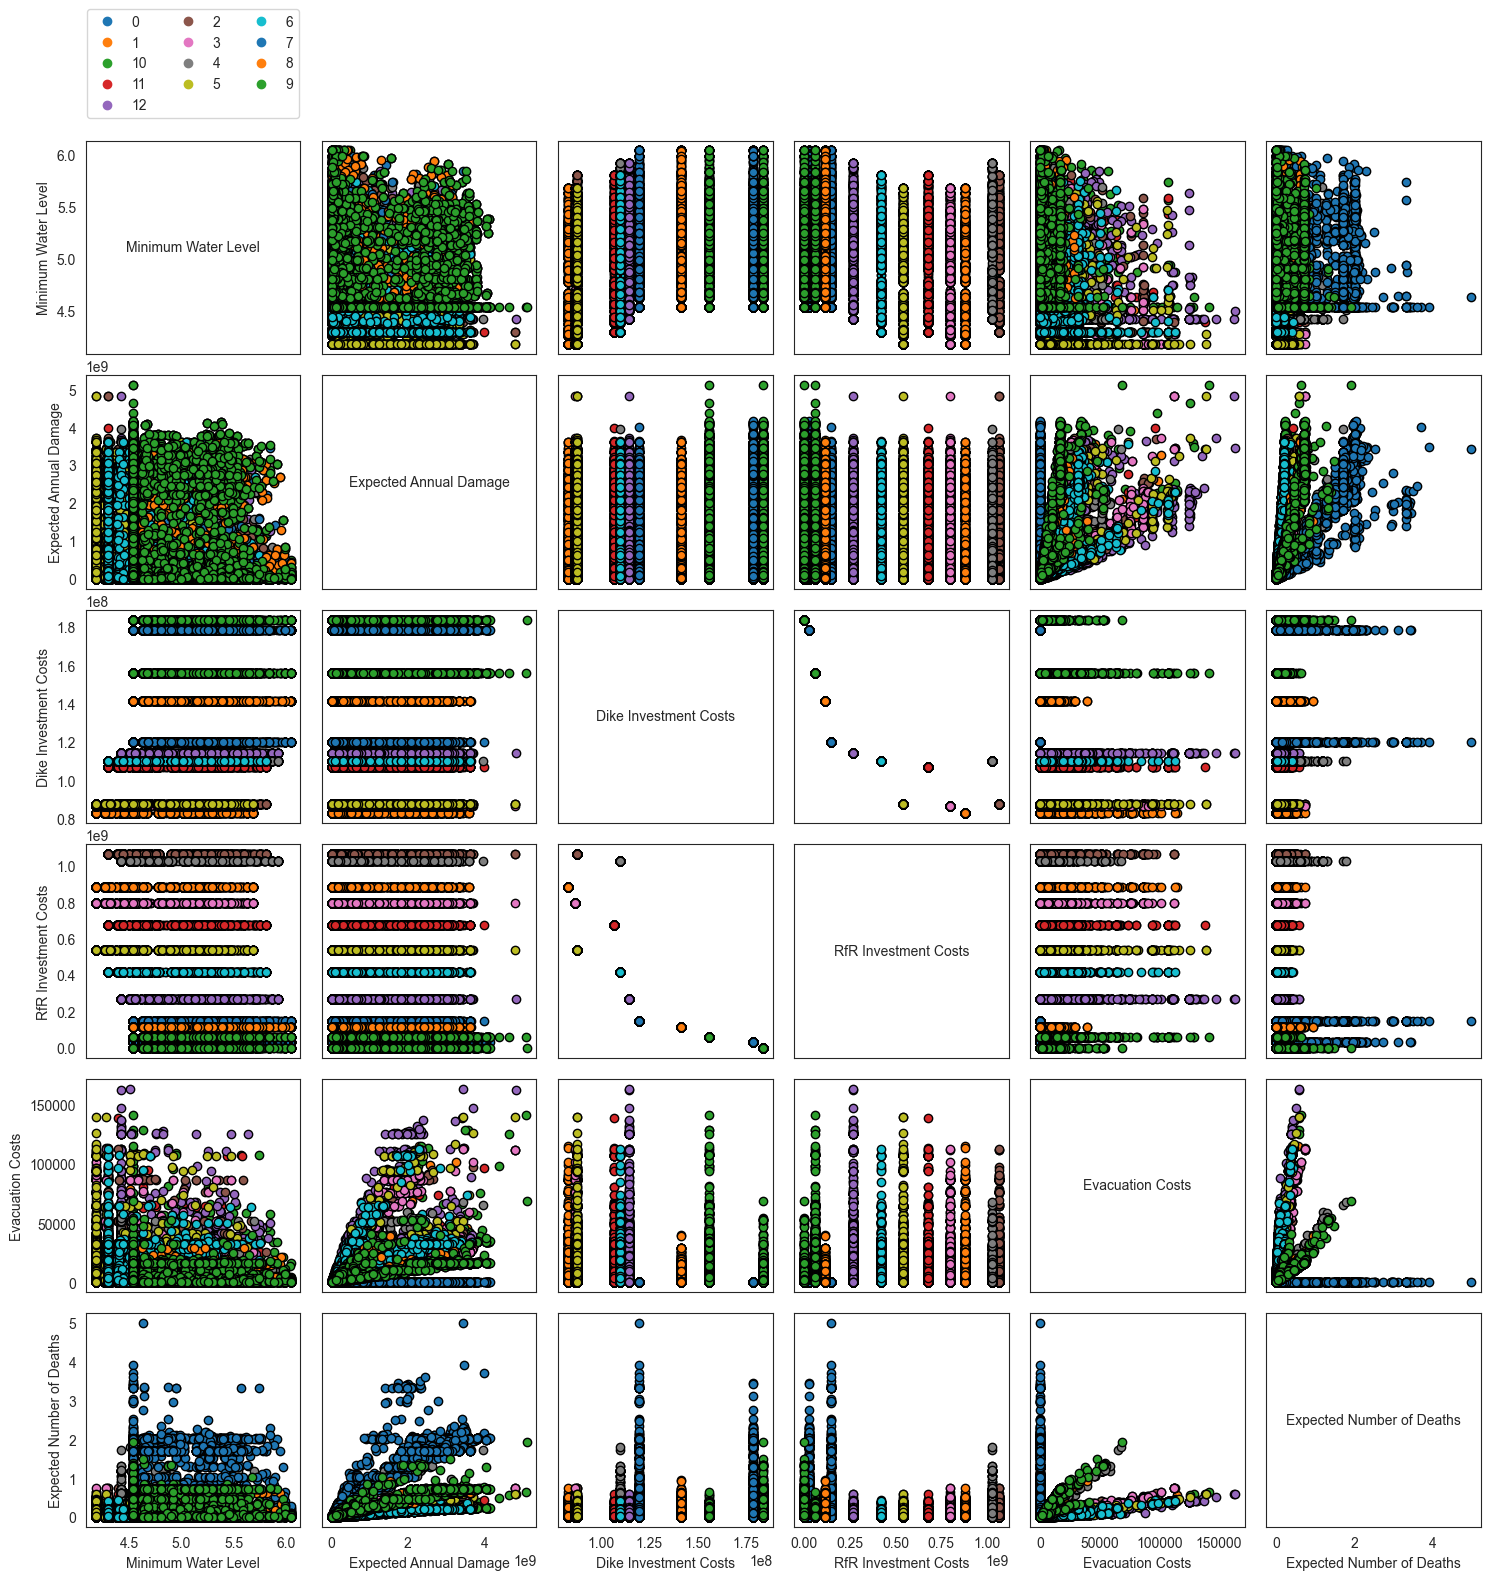

In [35]:
# Plot outcomes
#sns.pairplot(pd.DataFrame(outcomes))
from ema_workbench.analysis import pairs_plotting

fig, axes = pairs_plotting.pairs_scatter(experiments, outcomes,group_by='policy', legend=True, figsize=(10, 10))
fig.set_size_inches(18, 18)
plt.show()

## Robustness Metrics

**Signal to Noise**

The signal-to-noise ratio gives an indication of the variation of the outcomes over different scenarios. This metric captures both the average and the standard deviation of the candidate solution. By taking the standard deviation into account not only the average performance, but also the range of the performance of the candidate solutions becomes clear
The aim is to keep this variance as low as possible, as a
narrow range of uncertainty shows robustness (Kwakkel et al., 2016). When the objective needs to be minimised, the signal-to-noise ratio is calculated by multiplying the mean and the standard deviation, as both the mean and the standard deviation needs to be as low as possible. When maximising the objective, the signal-to-noise ratio is calculated by dividing the mean by the standard deviation, as the mean needs to be maximised, while having a minimal standard deviation. Thus, in case of maximisation of the objective, a high signal-to-noise ratio indicates robustness, while in case of minimisation, a low signal-to-noise ratio is preferred.

In [24]:
#Function to calculate the signal to noise ratio
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)

    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

In [25]:
#Calculate signal to noise scores for every candidate policy
overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}

    logical = experiments['policy']==policy

    for outcome in dike_model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T

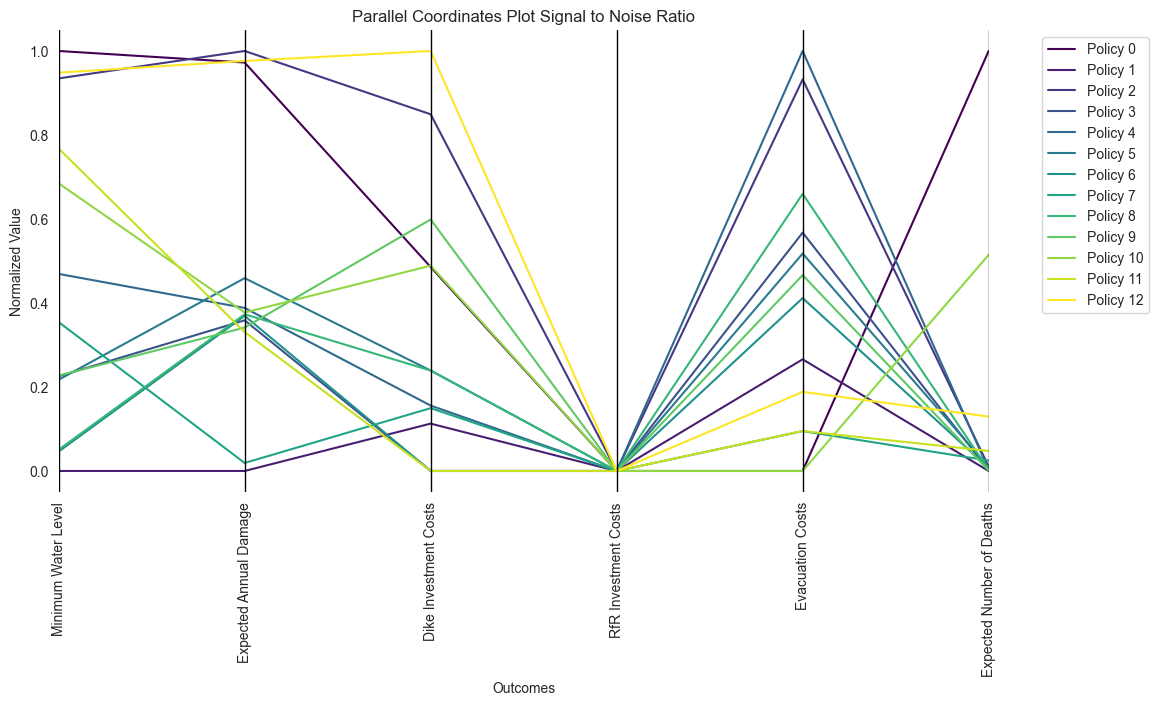

In [26]:
#Plotting with seaborn

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates

data1 = scores.copy()

# Normalize the data
zero_columns = data1.columns[(data1 == 0).all()]
data_normalized1 = data1.copy()
for col in data1.columns:
    if col not in zero_columns:
        data_normalized1[col] = (data1[col] - data1[col].min()) / (data1[col].max() - data1[col].min())

data_normalized1['class'] = ['Policy ' + str(i) for i in range(len(data_normalized1))]

plt.figure(figsize=(12, 6))
parallel_coordinates(data_normalized1, 'class', colormap=plt.get_cmap("viridis"))

plt.title("Parallel Coordinates Plot Signal to Noise Ratio")
plt.xlabel("Outcomes")
plt.ylabel("Normalized Value")

ax = plt.gca()

#Makes sure that x labels are vertically positioned
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

#Makes sure the legend is on the right side of the graph
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

#Remove the background grid
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.show()


**Maximum Regret**

 Defined for each policy under each scenario, as the difference between the performance of the policy in a specific scenario and the performance of a no-regret (i.e. best possible result in that scenario) policy. The maximum regret is then the maximum of such regret values across all scenarios. We of course favor policy options with low maximum regret values.

In [27]:
#Function to calculate regret
def calculate_regret(data, best):
    return np.abs(best - data)


#Calculate max regret for every policy
overall_regret = {}

In [28]:
#Calculate max regret for every policy
overall_regret = {}
max_regret = {}

for outcome in dike_model.outcomes:
    policy_column = experiments['policy']

    # create a DataFrame with all the relevent information
    data = pd.DataFrame({outcome.name: outcomes[outcome.name],
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})

    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')

    # flatten the resulting hierarchical index resulting from
    # pivoting
    data.columns = data.columns.get_level_values(1)

    # we need to control the broadcasting.
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across
    # the row and the actual values in the row
    outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()

    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

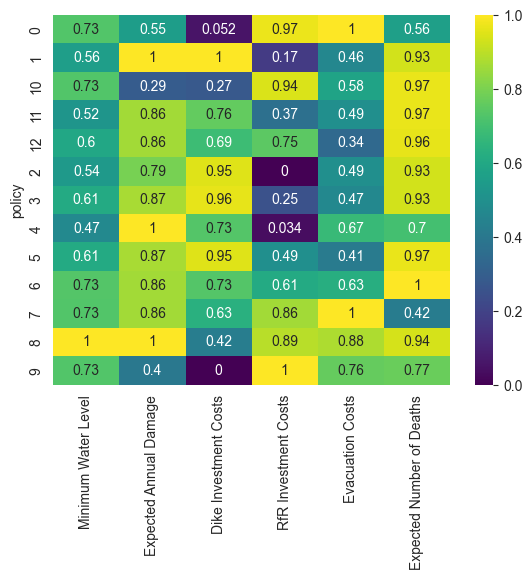

In [29]:
# Create heatmap
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.show()

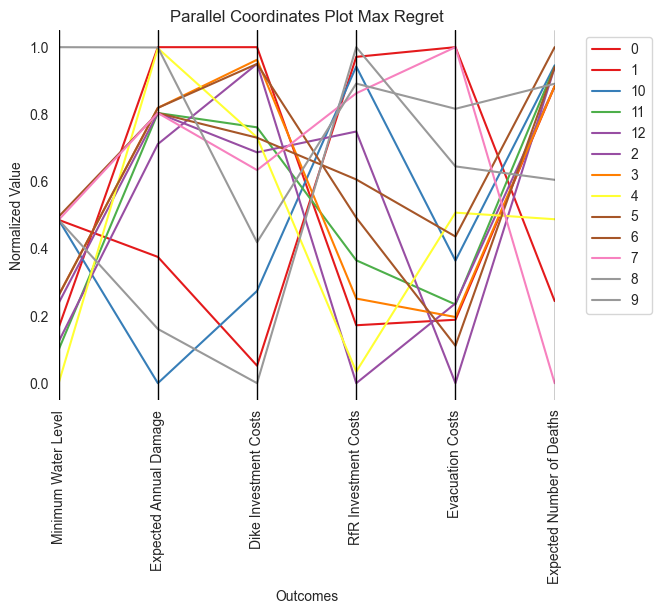

In [30]:
#Normalized values
data = max_regret.copy()
plt.style.use({'figure.facecolor': 'white'})

# Normalize the data
zero_columns = data.columns[(data == 0).all()]
data_normalized = data.copy()
for col in data.columns:
    if col not in zero_columns:
        data_normalized[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())
data_normalized = data_normalized.reset_index()

# Plot
parallel_coordinates(data_normalized, 'policy', colormap=plt.get_cmap("Set1"))

plt.title("Parallel Coordinates Plot Max Regret")
plt.xlabel("Outcomes")
plt.ylabel("Normalized Value")

ax = plt.gca()

#Makes sure that x labels are vertically positioned
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

#Makes sure the legend is on the right side of the graph
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

#Remove the background grid
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.show()




## Final Policies

In [31]:
# Create a list of final policies
robustness_policies = []
for policy in data_normalized.policy:
    robustness_policies.append(policy)

In [32]:
#Save the final output
experiments_final = experiments[experiments['policy'].isin(robustness_policies)]
outcomes_final = outcomes2.iloc[[i for i in experiments_final.index], :]

experiments_final.to_csv('Results/Final_policies_experiments.csv')
outcomes_final.to_csv('Results/Final_policies_outcomes.csv')

In [33]:
final=  pd.read_csv('Results/Final_policies_experiments.csv')

In [34]:
final

,Unnamed: 0,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model
0,0,38,144.941345,1.0,0.394920,311.407187,1.0,0.244993,118.479031,1.5,...,0,4,1,1,5,0,0,1,0,dikesnet
1,1,116,229.430620,1.5,0.283332,119.963173,1.5,0.820142,243.799559,1.0,...,0,4,1,1,5,0,0,2,0,dikesnet
2,2,1,345.356021,10.0,0.896687,210.716111,10.0,0.887580,305.966970,1.0,...,0,4,1,1,5,0,0,3,0,dikesnet
3,3,46,246.219200,10.0,0.574097,303.567106,1.5,0.093844,57.963694,1.5,...,0,4,1,1,5,0,0,4,0,dikesnet
4,4,10,272.859765,1.5,0.920711,120.048411,1.5,0.298038,63.539416,1.5,...,0,4,1,1,5,0,0,5,0,dikesnet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77995,77995,119,327.051985,1.5,0.949818,160.921776,1.5,0.082895,160.146926,10.0,...,0,5,0,0,4,0,0,5996,12,dikesnet
77996,77996,54,192.785630,1.0,0.413487,246.905480,1.5,0.335113,306.118768,1.5,...,0,5,0,0,4,0,0,5997,12,dikesnet
77997,77997,116,271.050000,10.0,0.344296,207.856490,1.0,0.841385,243.532948,10.0,...,0,5,0,0,4,0,0,5998,12,dikesnet
77998,77998,116,138.983583,10.0,0.555611,165.896683,1.0,0.906920,295.560246,1.5,...,0,5,0,0,4,0,0,5999,12,dikesnet
